### Знакомство с проектом

In [1]:
# подключили библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [3]:
# изучили информацию о столбцах
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [5]:
# изучили информацию о столбцах
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [7]:
# изучили информацию о столбцах
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


#### Поиск дубликатов

In [8]:
# посмотрели количество полных дубликатов
dfs = [visits, orders, costs]
for df in dfs:
    print(df.duplicated().sum())

0
0
0


In [9]:
# проверили наличие дубликатов в столбцах с категориями
print(visits['Region'].value_counts())
print()
print(visits['Device'].value_counts())
print()
print(visits['Channel'].value_counts())
print()
costs['Channel'].value_counts()

United States    207327
UK                36419
France            35396
Germany           30759
Name: Region, dtype: int64

iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: Device, dtype: int64

organic               107760
TipTop                 54794
FaceBoom               49022
WahooNetBanner         20465
LeapBob                17013
OppleCreativeMedia     16794
RocketSuperAds         12724
YRabbit                 9053
MediaTornado            8878
AdNonSense              6891
lambdaMediaAds          6507
Name: Channel, dtype: int64



FaceBoom              180
MediaTornado          180
RocketSuperAds        180
TipTop                180
YRabbit               180
AdNonSense            180
LeapBob               180
OppleCreativeMedia    180
WahooNetBanner        180
lambdaMediaAds        180
Name: Channel, dtype: int64

- в датасетах нет пропусков и дубликатов;
- для дальнейшего исследования в датасетах нужно привести столбцы с датами к типу datetime;
- во всех датасетах для удобства работы нужно переименовать столбцы.

In [10]:
# переименовали столбцы
for df in dfs:
    df.columns = df.columns.str.lower().str.replace(' ', '_')

In [11]:
# привели к типу datetime
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
for df in dfs:
    df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.

**Вывод:**

Исходные данные хорошего качества - нет пропусков и дубликатов. Небольшое замечание: названия столбцов неудобны для работы и некоторые столбцы не того типа.

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [12]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [13]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [14]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [15]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [16]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [17]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [18]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [19]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

#### Профили пользователей

In [20]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
display(profiles.head(15))

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
5,34186288,2019-05-09 17:29:23,organic,Android,United States,2019-05-09,2019-05-01,False,0.000000
6,38448301,2019-08-16 11:56:00,organic,Android,United States,2019-08-16,2019-08-01,False,0.000000
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
8,58263264,2019-05-11 19:18:43,FaceBoom,iPhone,United States,2019-05-11,2019-05-01,False,1.128205
9,59835779,2019-05-11 21:13:47,MediaTornado,iPhone,United States,2019-05-11,2019-05-01,False,0.250435


In [21]:
# минимальная дата привлечения пользователей
min_analysis_date = profiles['first_ts'].min()
print(min_analysis_date)
max_analysis_date = profiles['first_ts'].max()
max_analysis_date

2019-05-01 00:00:41


Timestamp('2019-10-27 23:59:04')

В датафреймах хранится информация о пользователях, которые привлекались **начиная с 1 мая и заканчивая 27 октября 2019 года**.

- приложение устанавливают пользователи из разных стран и с разных устройств;
- пользователи приходят из разных источников, в т.ч. из органического трафика, стоимость привлечения таких пользователей равна нулю;
- иногда пользователи совершают покупки;
- реклама должна окупаться не позднее чем через две недели после привлечения, значит, горизонт анализа - 14 дней;
- на календаре 1 ноября 2019 года - это момент анализа;
- в датасетах хранится информация о пользователях, привлеченных с 1 мая 2019 года;
- чтобы пользователи успели "дожить" две недели, нужно рассматривать только пользователей привлеченных не позднее 19 октбяря.

#### Исследование пользователей по странам

In [22]:
# построили таблицу с количеством уникальных пользователей из каждой страны и долей платящих пользователей
regions = profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'mean'})\
    .sort_values(by='payer', ascending=False).reset_index().rename(columns={'region': 'Страна', \
    'user_id': 'Пользователи','payer':'Доля платящих'})
regions['Доля платящих'] = regions['Доля платящих'].map(lambda x: f'{x:,.0%}')
regions

,Страна,Пользователи,Доля платящих
0,United States,100002,7%
1,Germany,14981,4%
2,UK,17575,4%
3,France,17450,4%


- больше всего пользователей приходят из США, также приходят пользователи из Германии, Великобритании и Франции;
- доля платящих пользователей существенно выше среди пользователей из США.

#### Исследование пользователей по устройствам

In [23]:
# построили таблицу с количеством уникальных пользователей, заходящих с разных устройств,
# и долей платящих пользователей
devices = profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'mean'})\
.sort_values(by='payer', ascending=False).reset_index().rename(columns={'device': 'Устройство', \
    'user_id': 'Пользователи','payer':'Доля платящих'})
devices['Доля платящих'] = devices['Доля платящих'].map(lambda x: f'{x:,.0%}')
devices

,Устройство,Пользователи,Доля платящих
0,Mac,30042,6%
1,iPhone,54479,6%
2,Android,35032,6%
3,PC,30455,5%


- больше всего пользователей заходят с iPhone, также пользователи заходят с Android, Mac и PC;
- доля платящих пользователей выше среди пользователей, заходящих с Mac и iPhone;
- доля платящих пользователей ниже среди пользователей, заходящих с Android, и самая низкая среди тех, кто заходит с PC.

#### Исследование пользователей по каналам привлечения

In [24]:
# построили таблицу с количеством уникальных пользователей с разных каналов привлечения
# и долей платящих из них пользователей

channels = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': 'mean'})\
.sort_values(by='payer', ascending=False).reset_index().rename(columns={'channel': 'Канал', \
    'user_id': 'Пользователи','payer':'Доля платящих'})
channels['Доля платящих'] = channels['Доля платящих'].map(lambda x: f'{x:,.0%}')
channels

,Канал,Пользователи,Доля платящих
0,FaceBoom,29144,12%
1,AdNonSense,3880,11%
2,lambdaMediaAds,2149,10%
3,TipTop,19561,10%
4,RocketSuperAds,4448,8%
5,WahooNetBanner,8553,5%
6,YRabbit,4312,4%
7,MediaTornado,4364,4%
8,LeapBob,8553,3%
9,OppleCreativeMedia,8605,3%


- больше всего пользователей приходят из органического трафика, а также с каналов FaceBoom и TipTop;
- доля платящих пользователей выше среди тех, кто пришел с FaceBoom, AdNonSense, lambdaMediaAds и TipTop;
- самая низкая доля платящих пользователей среди тех, кто пришел с органики.

**Выводы:**
- в датафреймах хранится информация о пользователях, которые привлекались начиная с 1 мая и заканчивая 27 октября 2019 года;
- больше всего пользователей приходят из США, также приходят пользователи из Германии, Великобритании и Франции, а доля платящих пользователей существенно выше среди пользователей из США;
- больше всего пользователей заходят с iPhone, также пользователи заходят с Android, Mac и PC, а доля платящих пользователей выше среди тех, кто заходит с Mac и iPhone;
- больше всего пользователей приходят из органического трафика, среди них самая низкая доля платящих;
- также много пользователей приходят с FaceBoom и TipTop, доля платящих среди них высокая;
- также доля платящих высокая среди тех, кто пришел с AdNonSense и lambdaMediaAds, но таких пользователей немного.

### Маркетинг

In [25]:
# посчитали общую сумму расходов на маркетинг за весь период
print('Общая сумма расходов на рекламу:', round(costs['costs'].sum()))

Общая сумма расходов на рекламу: 105497


In [26]:
# посчитали сумму расходов по каждому источнику
channels = costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)\
.reset_index().rename(columns={'channel': 'Канал', \
    'costs': 'Расходы на рекламу'})
channels

,Канал,Расходы на рекламу
0,TipTop,54751.30
1,FaceBoom,32445.60
2,WahooNetBanner,5151.00
3,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
6,LeapBob,1797.60
7,lambdaMediaAds,1557.60
8,MediaTornado,954.48
9,YRabbit,944.22


In [27]:
# переводим столбец с датой в формат datetime, чтобы получить номер месяца/недели 
costs['date'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['date'].dt.isocalendar().week # вычисляем номера недель
costs['month'] = costs['date'].dt.month # вычисляем номер месяца

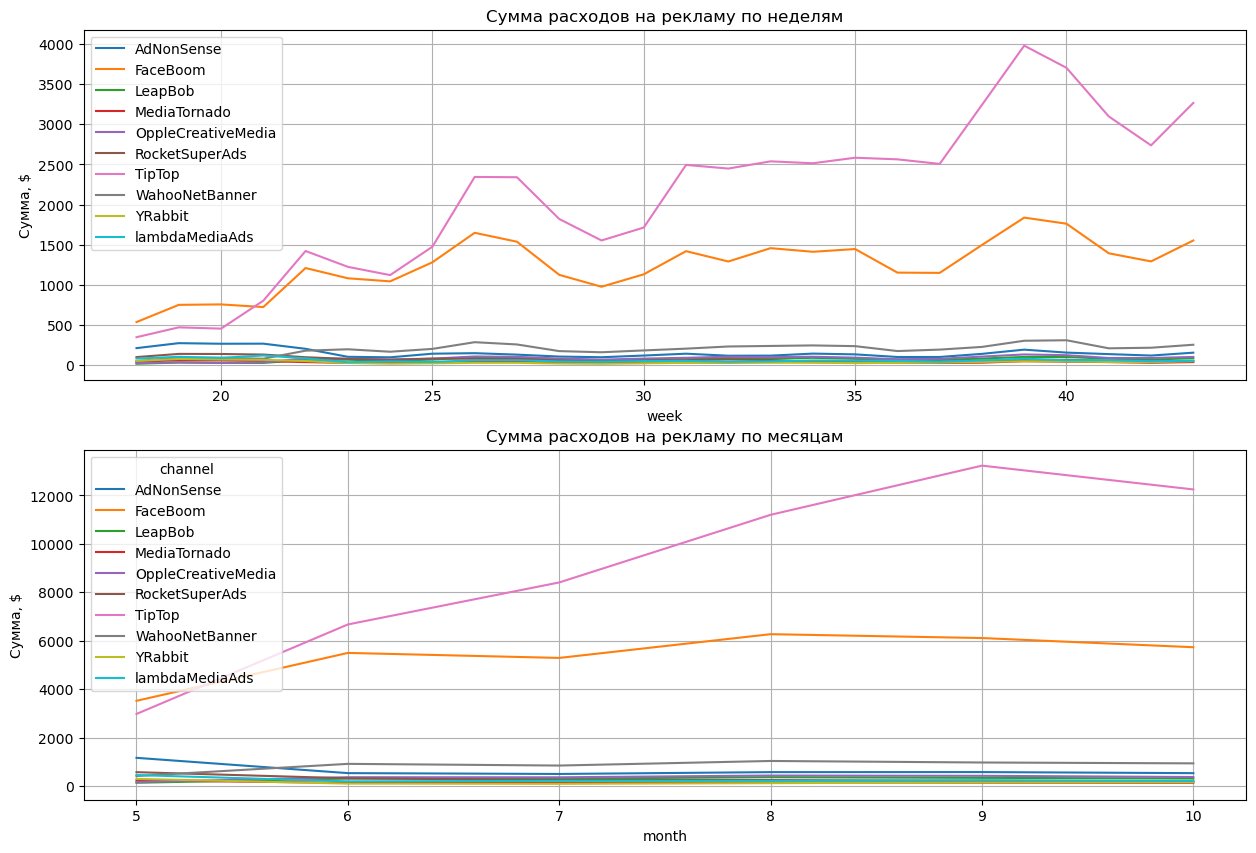

In [28]:
# задаём размер сетки для графиков
plt.figure(figsize=(15, 10))
    
# в таблице графиков — два столбца и одна строка, две ячейки
# в первой визулизировали расходы по каждому каналу и по каждой неделе
costs.pivot_table(
    index='week',  # неделя, на которой закупают рекламу
    columns='channel',  # источиники
    values='costs',  # сумма расходов на источник
    aggfunc='sum' 
).plot(figsize=(15, 10), grid=True, ax=plt.subplot(2, 1, 1))
plt.legend()
plt.title('Сумма расходов на рекламу по неделям')
plt.ylabel('Сумма, $')

# во второй ячейке визулизировали расходы по каждому каналу и по каждому месяцу
costs.pivot_table(
    index='month',  # неделя, на которой закупают рекламу
    columns='channel',  # источиники
    values='costs',  # сумма расходов на источник
    aggfunc='sum' 
).plot(figsize=(15, 10), grid=True, ax=plt.subplot(2, 1, 2))
plt.title('Сумма расходов на рекламу по месяцам')
plt.ylabel('Сумма, $')

plt.show()

In [29]:
# посчитали среднюю стоимость привлечения одного пользователя
cac_mean = profiles.query('channel != "organic"')
cac_mean = cac_mean['acquisition_cost'].mean()
print('Средняя стоимость привлечения одного пользователя', cac_mean)
# сгруппировали пользователей по каналам привлечения и посчитали среднюю цену привлечения
cac = profiles.query('channel != "organic"').groupby('channel').agg({'acquisition_cost': 'mean'}).sort_values('acquisition_cost', ascending=False)\
.reset_index().rename(columns={'channel': 'Канал', \
    'acquisition_cost': 'CAC'})
display(cac)
print('Средний CAC:', cac['CAC'].mean())

Средняя стоимость привлечения одного пользователя 1.127481323942928


,Канал,CAC
0,TipTop,2.799003
1,FaceBoom,1.113286
2,AdNonSense,1.008054
3,lambdaMediaAds,0.724802
4,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
6,OppleCreativeMedia,0.250000
7,YRabbit,0.218975
8,MediaTornado,0.218717
9,LeapBob,0.210172


Средний CAC: 0.7557348976115397


**Выводы:**
- основная часть расходов на рекламу приходится на каналы TipTop и FaceBoom;
- расходы на эти каналы постепенно росли к сентябрю, после сентября расходы на них немного снизились;
- CAC пользователей из TipTop выше средней стоимости привлечения, CAC пользователей из FaceBoom почти равен средней стоимости привлечения;
- OppleCreativeMedia, YRabbit, MediaTornado, LeapBob имеют низкую стоимость привлечения пользователя - около 0.2$.

### Оценка окупаемости рекламы

#### Окупаемость рекламы

Чтобы точнее оценить окупаемость, убираем пользователей, пришедших из органики.

Согласно заданию, нужно проанализировать окупаемость рекламы, считая, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. 

Значит, **1 ноября 2019 года - момент анализа**, а **горизонт анализа -  две недели (14 дней)**.

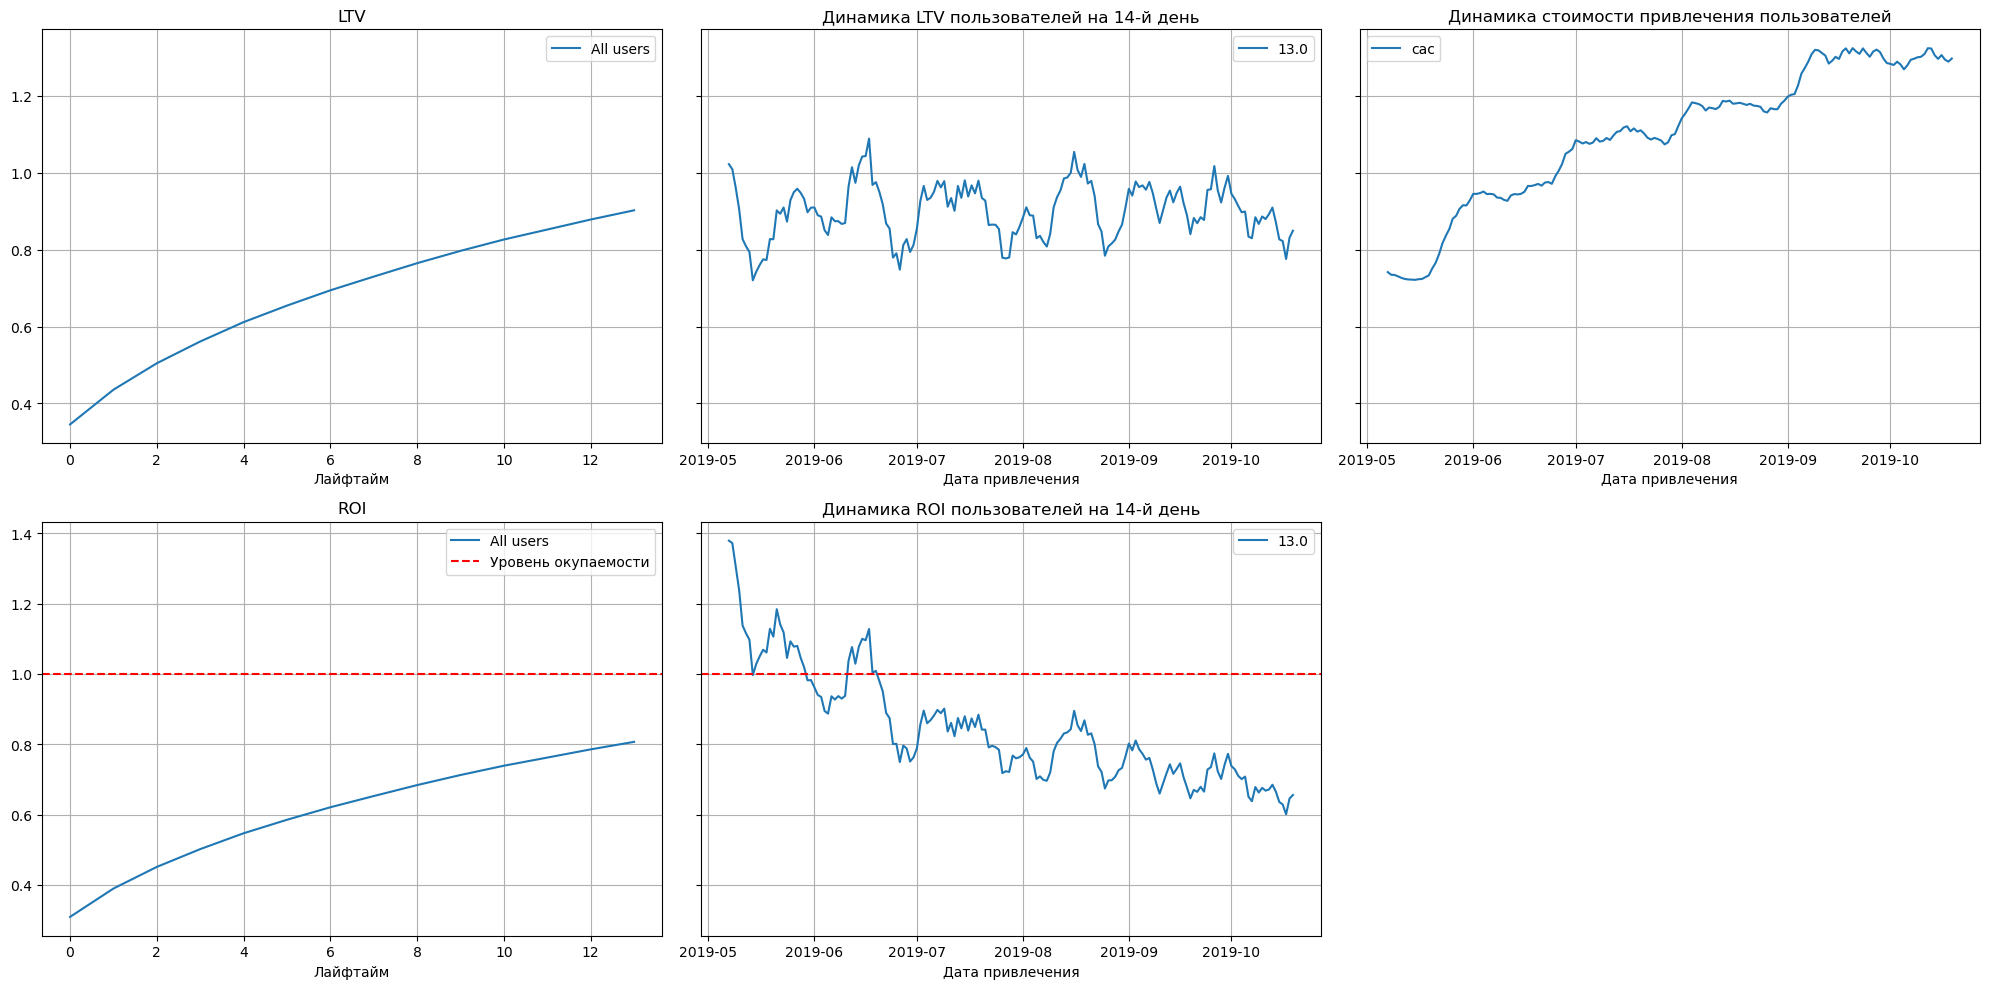

In [30]:
# убрали пользователей из органики
profiles = profiles.query('channel != "organic"')
# задаем горизонт анализа и момент анализа
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

LTV пользователей по дням растет и к 14-му дню приближается к 0.9$. LTV в динамике с мая постоянно колеблется около одного уровня. Значит, дело не в прдажах.

CAC в динамике с мая постоянно расет (с 0.8 до 1.2$ за клиента). Значит расходы на рекламу постоянно растут.

Это подтверждается тем, что ROI к 14-му дню так и не достигает уровня окупаемости, и в динамике с мая постоянно падает. Значит, окупаемость расходов на рекламу падает.

#### Общая конверсия и удержание

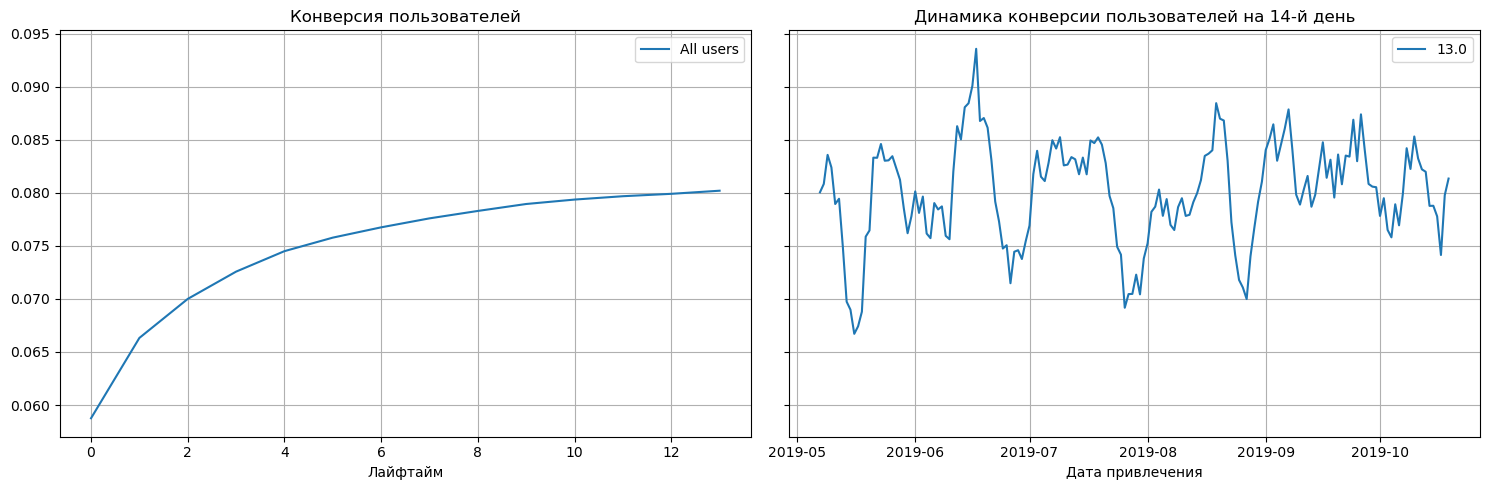

In [31]:
# считаем конверсию неплатящих пользователей в платящих
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date,horizon_days,dimensions=[])
# строим графики
plot_conversion(conversion, conversion_history, horizon_days, window=7)

Конверсия в покупателей растет с лайфтаймом, как и должно быть. Ко второй неделе около 8% пользователей делают покупки. В динамике с мая коверсия на 14-й деньпостоянно колеблется на одном уровне. Скорее всего, дело не в конверсии.

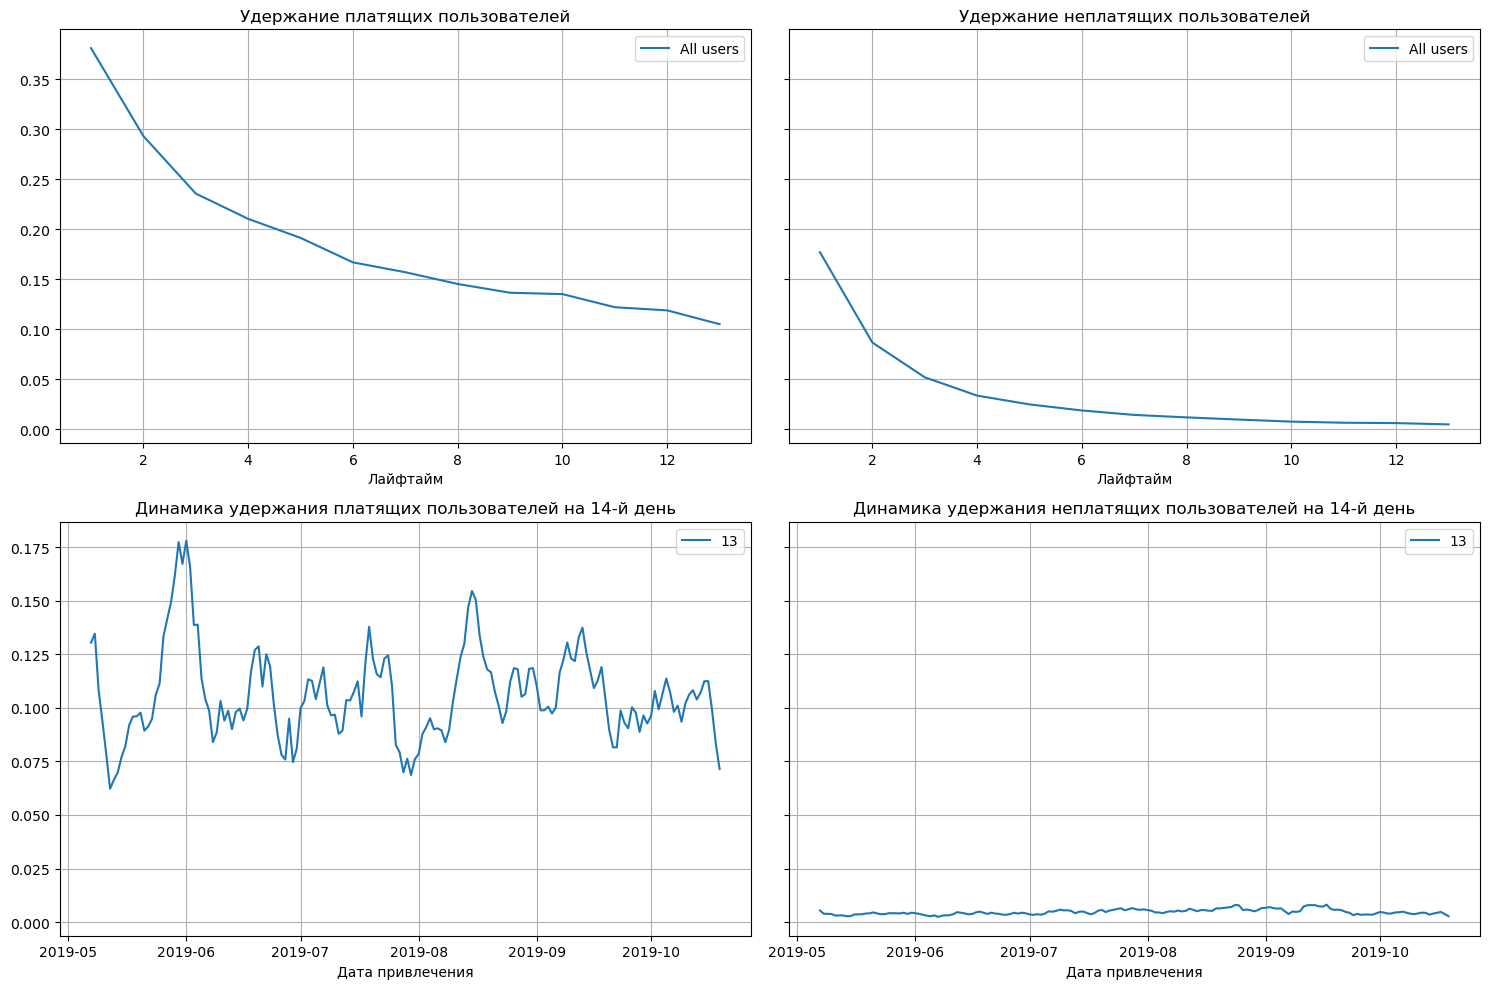

In [32]:
# считаем удержание
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=[]
)
# строим графики
plot_retention(retention, retention_history, horizon_days, window=7)

Удержание платящих и неплатящих пользователей снижается к 14-му дню. Удержание на 14-й день в динамике с мая колеблется на одном уровне. Удержание неплатящих пользователей ниже, чем платящих. Здесь тоже нет ничего необычного.

#### Окупаемость рекламы с разбивкой по устройствам

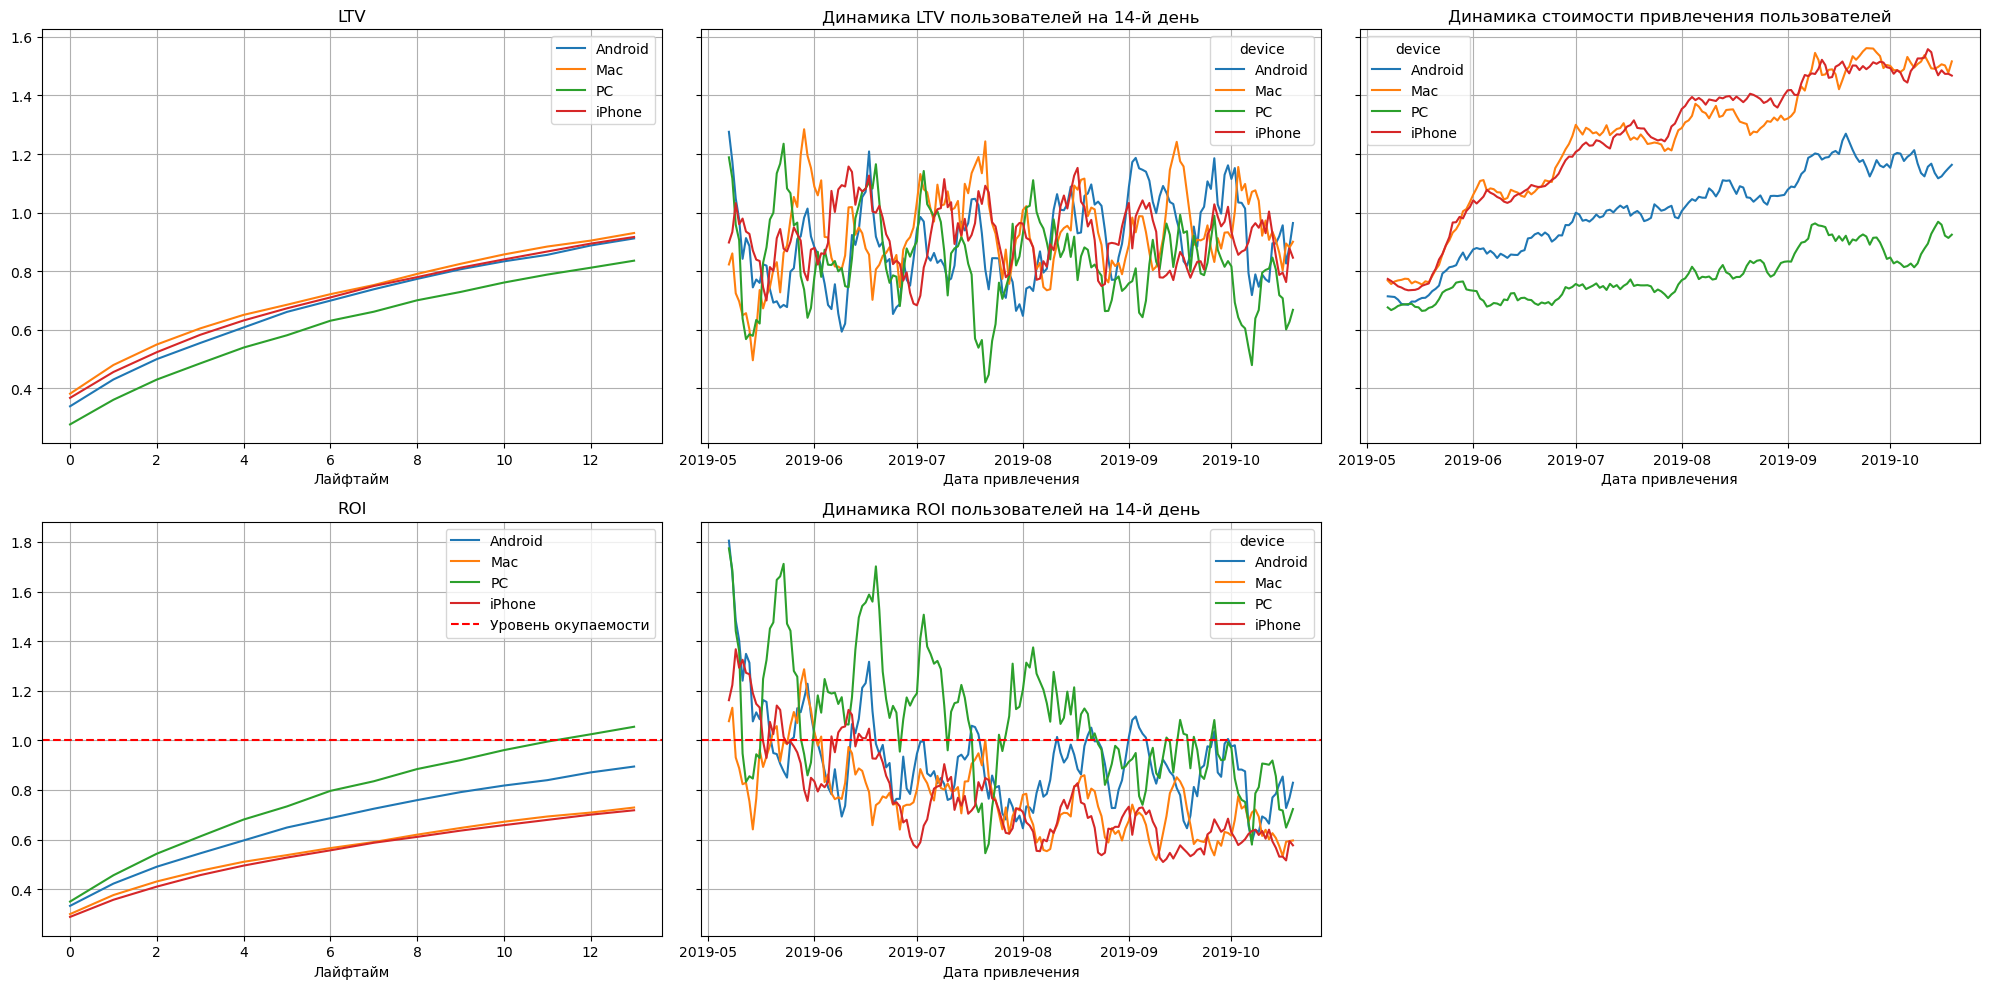

In [33]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device'],
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

LTV пользователей PC ниже, чем для остальных платформ, значит, эти пользователи приносят меньше денег. LTV на 14-й день в динамике по устройствам постоянно колеблется около одного уровня. 

CAC пользователей всех платформ растет в динамике, причем CAC пользователей Mac и iPhone растет более быстрыми темпами.

К 14-му дню окупается только привлечение пользователей PC, на рекламу которых было потрачено меньше денег. Окупаемость на 14-й день в динамике с мая постоянно падает для всех устройств.

Скорее всего, дело не в конкретных устройствах, с которых заходят пользователи.

#### Окупаемость рекламы с разбивкой по странам

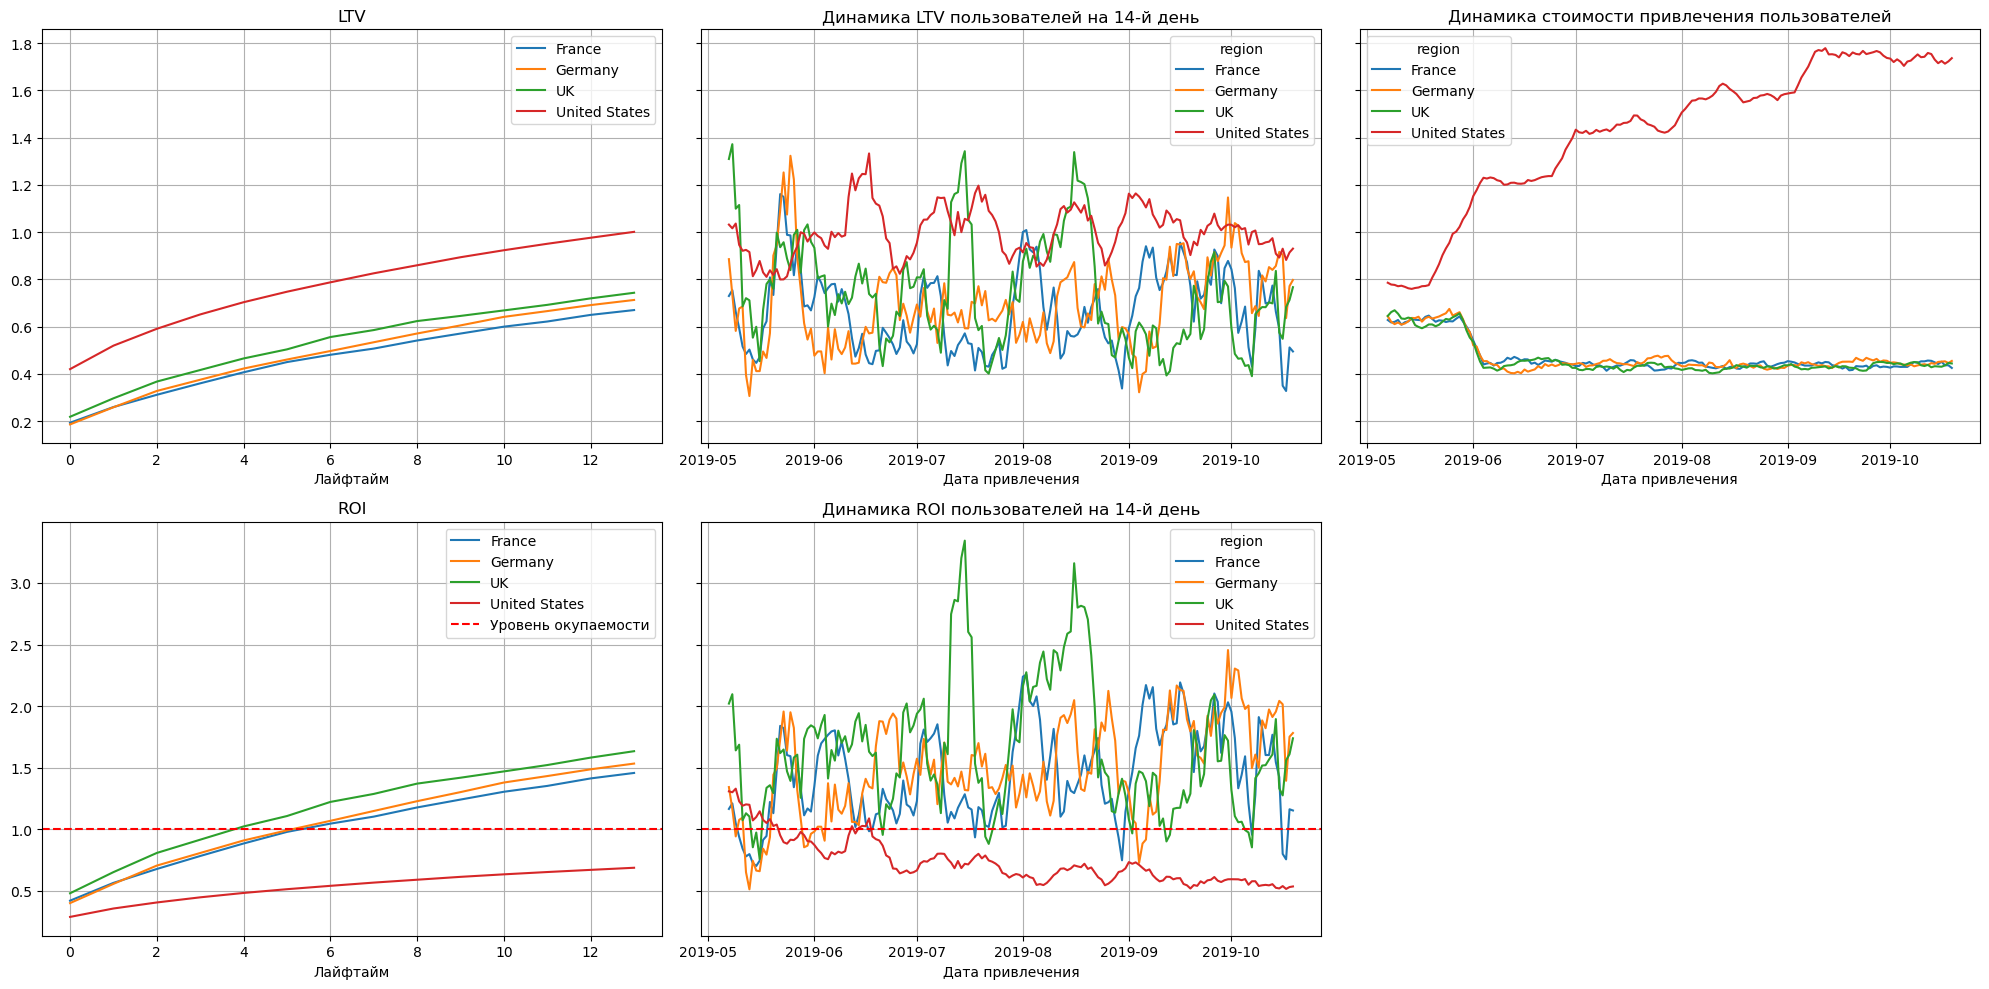

In [34]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region'],
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

LTV пользователей из США выше во все лайфтаймы. В динамике LTV на 14-й день пользователей всех стран колеблется около одного уровня.

К июню стоимость привлечения пользователей из США резко возрасла, а из других стран - упала. После этого стоимость привлечения пользователей из США постоянно растет, а для других пользователей остается на одном уровне.

Окупаемость привлечения пользователей из США ниже, чем для других стран: только пользователи из США не окупаются к 14-му дню. Динамика окупаемости пользователей из США постоянно снижается.

Это значит, что рекламный бюджет для пользователей из США постоянно расет, но это никак не увеличивает продажи.

#### Окупаемость рекламы с разбивкой по каналам

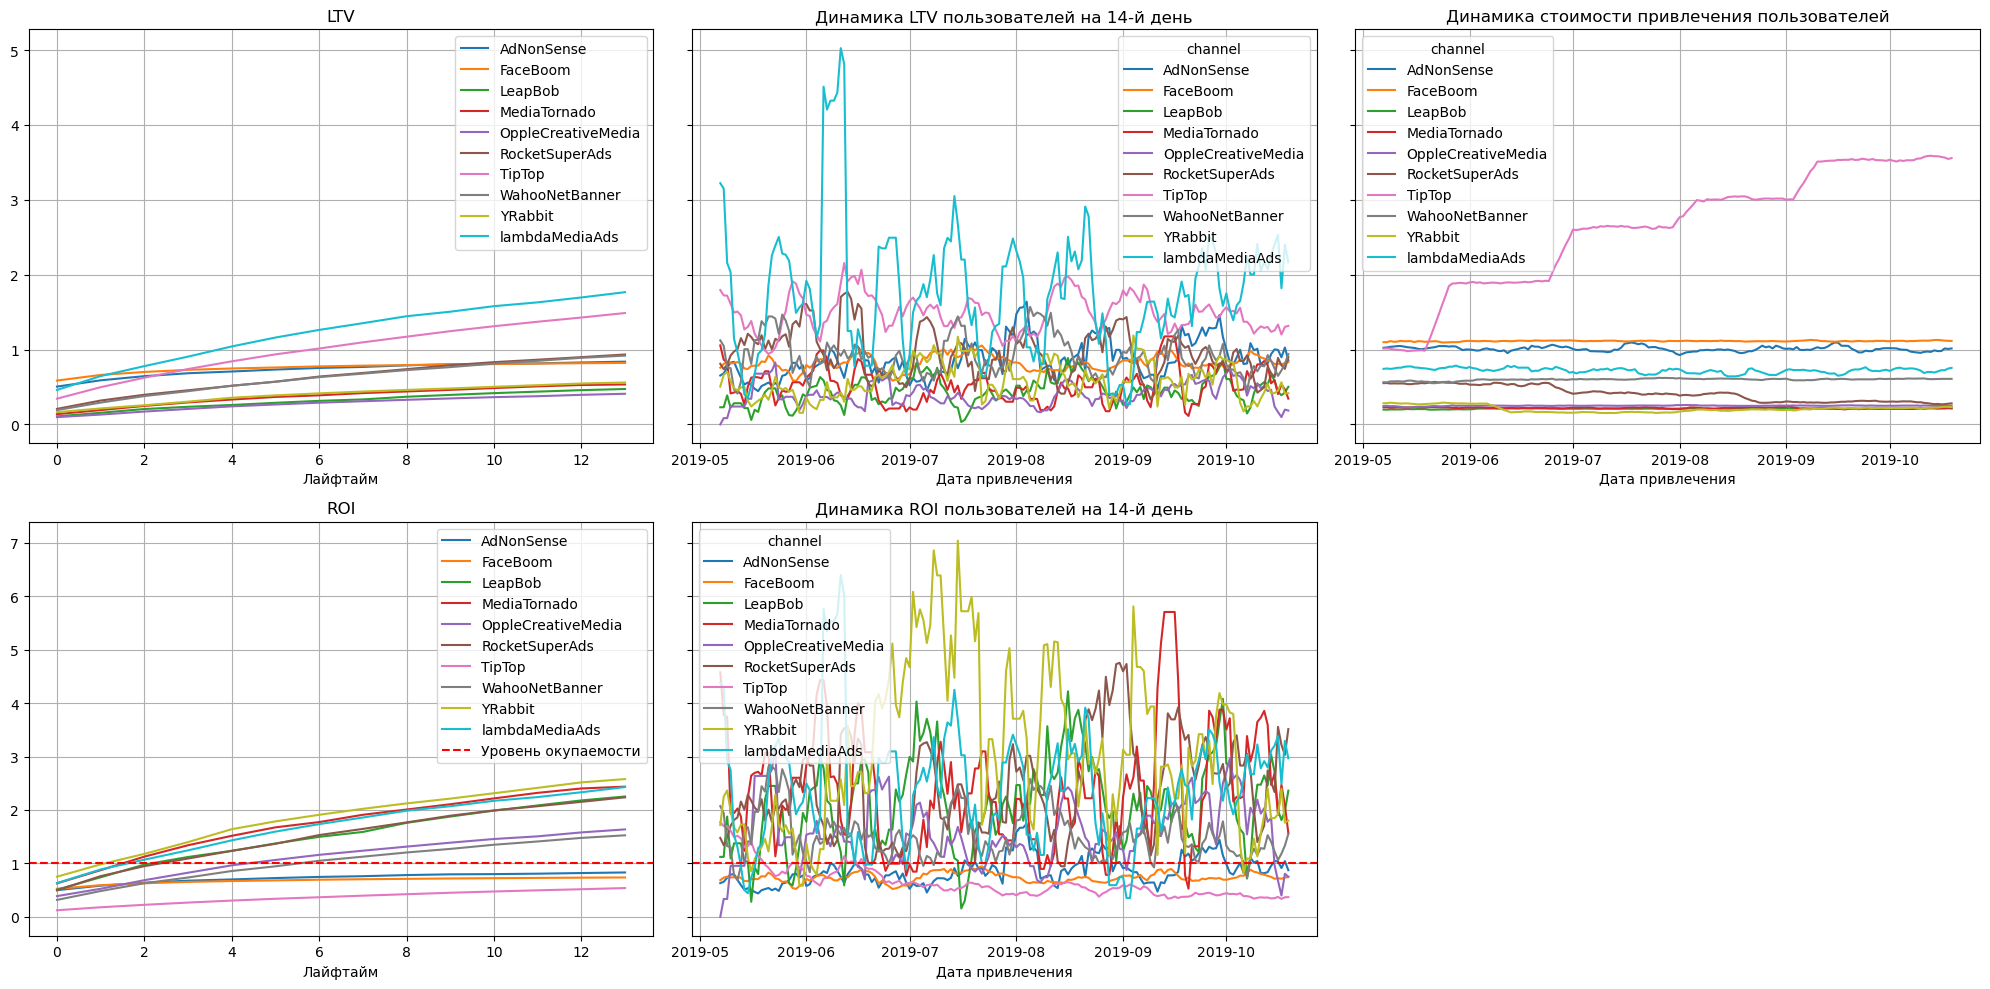

In [35]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'],
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

LTV пользователей, пришедших из lambdaMediaAds и TipTop, выше, чем у остальных, значит эти пользователи приносят больше денег. LTV в динамике на 14-й день в разбивке по платформам постоянно колеблется около одного уровня.

Стоимость привлечения пользователя стаблильно на одном уровне для всех каналов, кроме TipTop, что говорит о том, что на рекламу из этого источника бюджет постоянно увеличивается. После TipTop самые высокие рекламные бюджеты у AdNonSense и FaceBoom.

Однако потраченные на TipTop (и еще на AdNonSense и FaceBoom) так и деньги не окупаются к 14-му дню жизни. Тогда как для других каналов окупаются.

Все это говорит о том, что закупка рекламы в больших объемах у каналов TipTop, AdNonSense и FaceBoom не приводит к увеличению покупок и снижает окупаемость инвестиций.

#### Конверсия и удержание по каналам, странам, устройствам

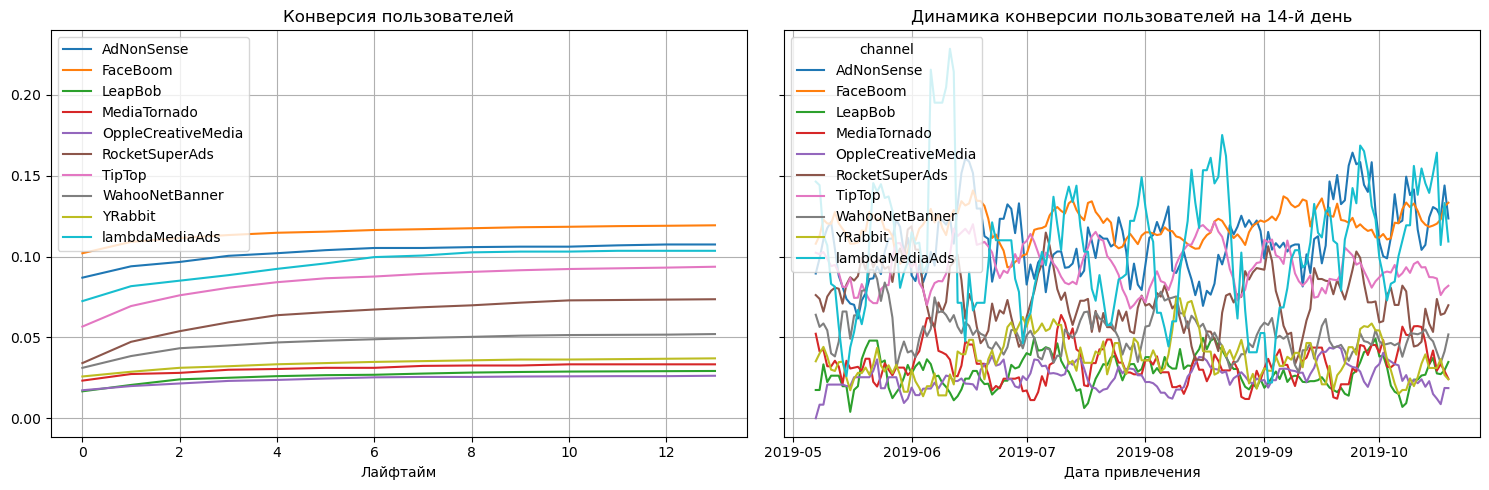

In [36]:
# считаем конверсию неплатящих пользователей в платящих по каналам
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date,horizon_days,dimensions=['channel'])
# строим графики
plot_conversion(conversion, conversion_history, horizon_days, window=7)

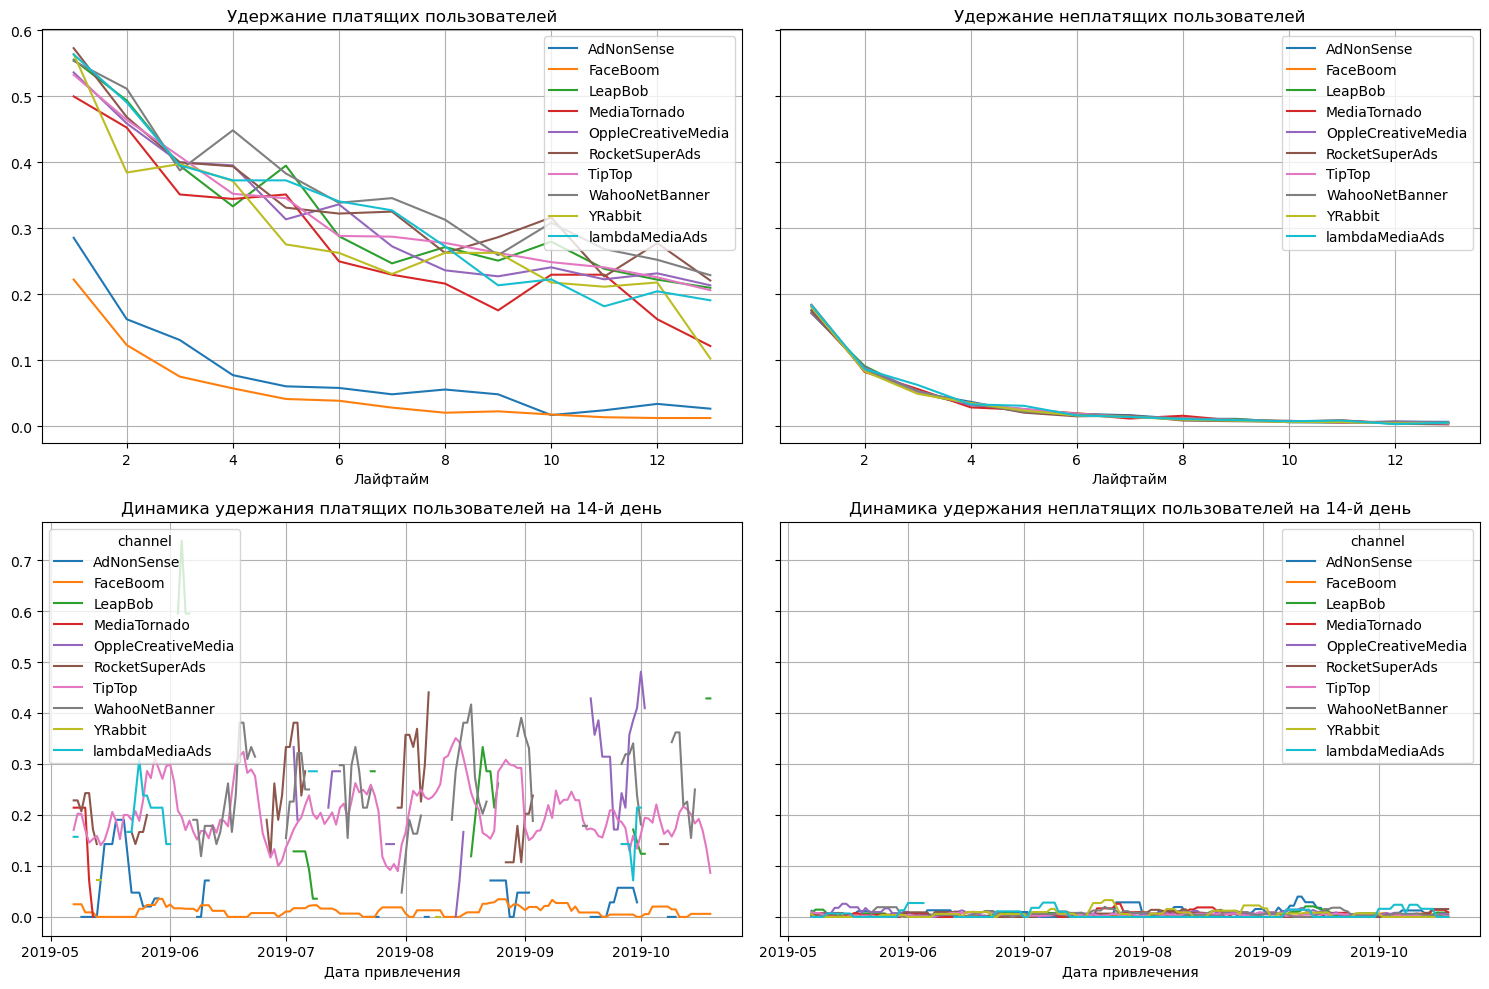

In [37]:
# считаем удержание по каналам
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)
# строим графики
plot_retention(retention, retention_history, horizon_days, window=7)

Пользователи, привлеченные через FaceBoom, AdNonSense, lambdaMediaAds и TipTop, быстрее конвертируются в платящих пользователей. Но сделав покупку, пользователи, привлеченные через FaceBoom и AdNonSense, плохо удерживаются, т.е. перестают заходить в приложение.

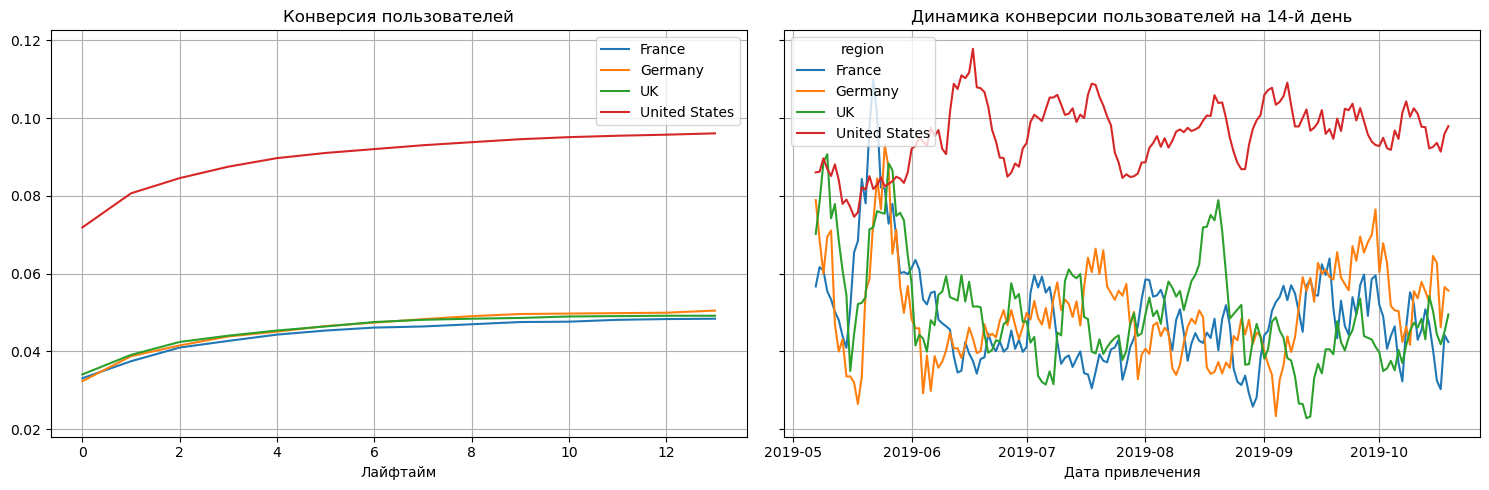

In [38]:
# считаем конверсию неплатящих пользователей в платящих по странам
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date,horizon_days,dimensions=['region'])
# строим графики
plot_conversion(conversion, conversion_history, horizon_days, window=7)

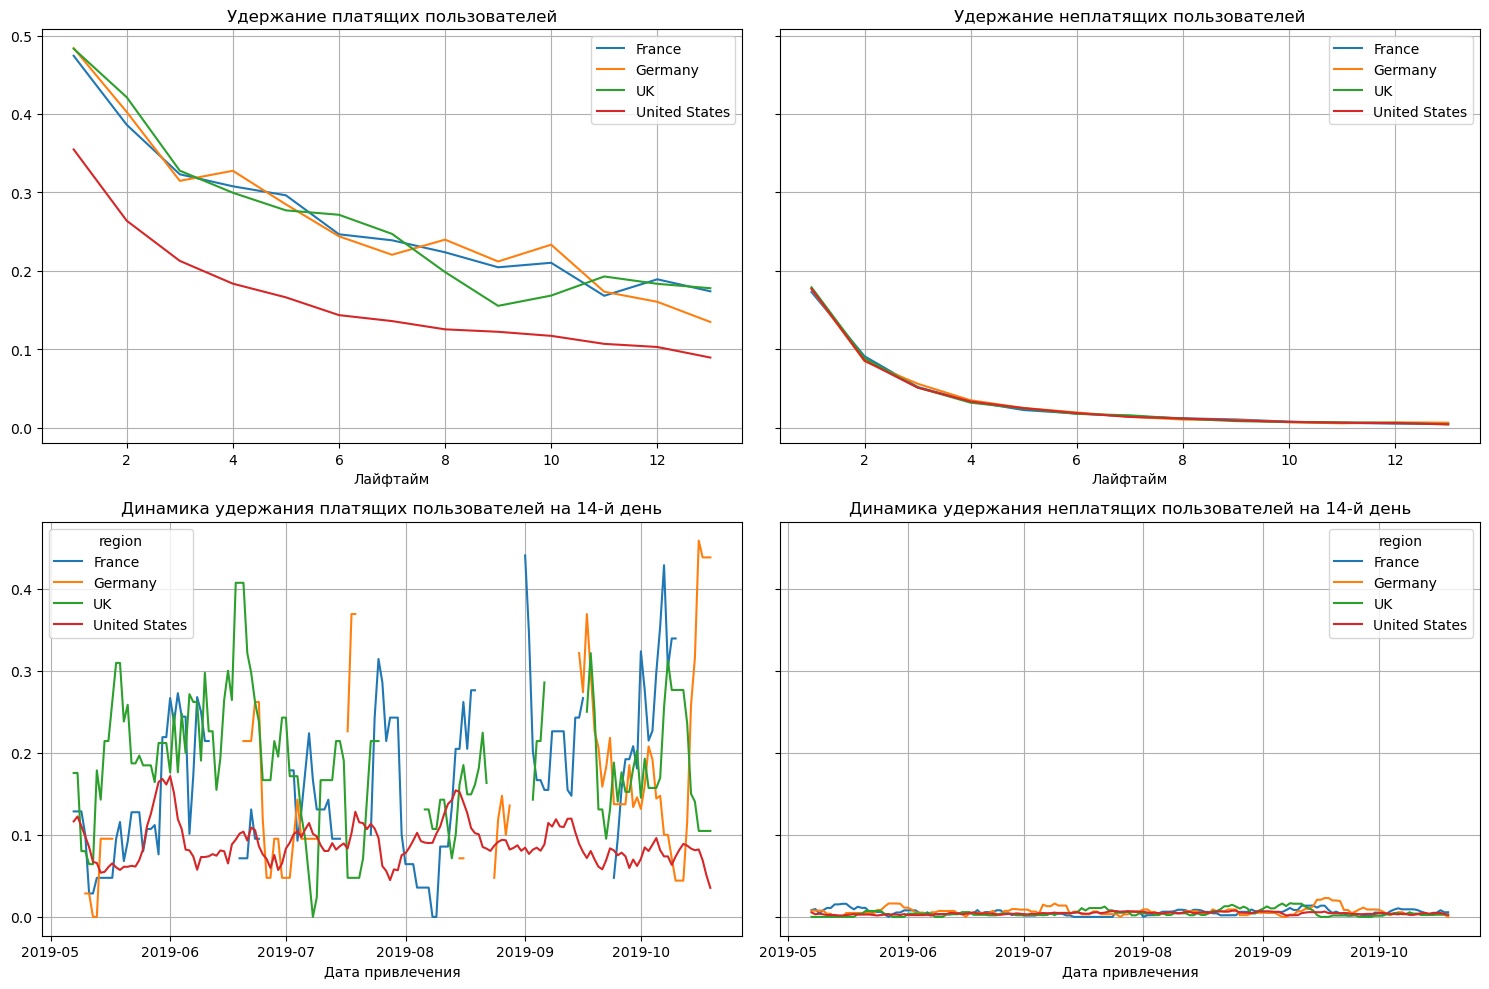

In [39]:
# считаем удержание по странам
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)
# строим графики
plot_retention(retention, retention_history, horizon_days, window=7)

Пользователи из США конвертируются в платящих быстрее, чем пользователи из других стран. Но они хуже удерживаются, т.е. совершив покупку, пользователи из США перестают заходить в приложение.

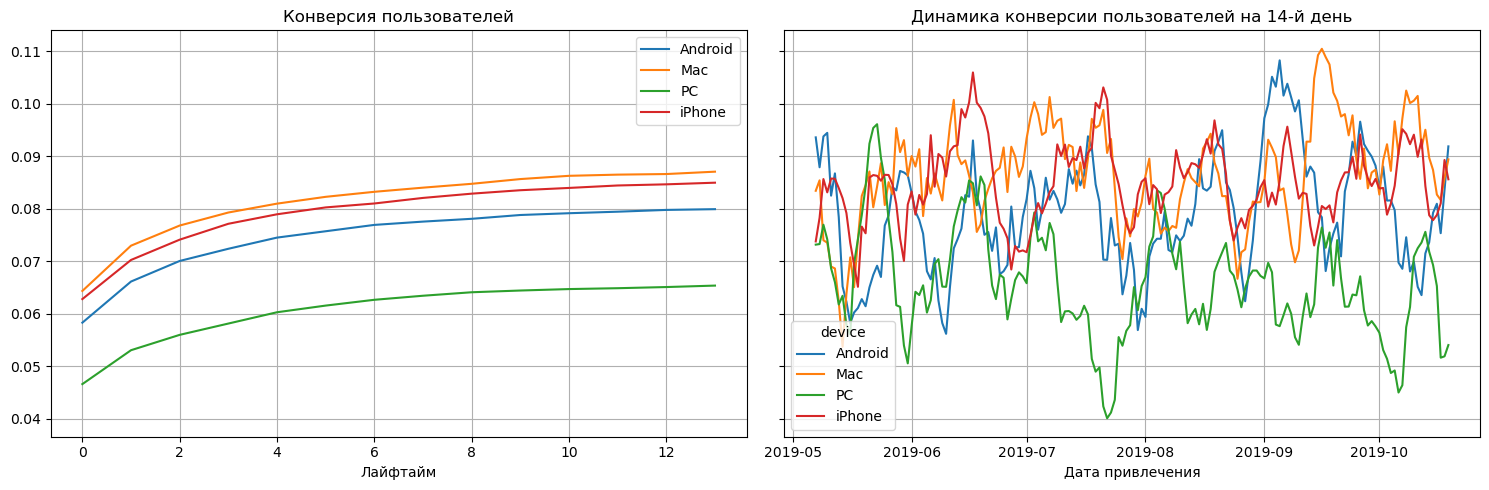

In [40]:
# считаем конверсию неплатящих пользователей в платящих по устройствам
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date,horizon_days,dimensions=['device'])
# строим графики
plot_conversion(conversion, conversion_history, horizon_days, window=7)

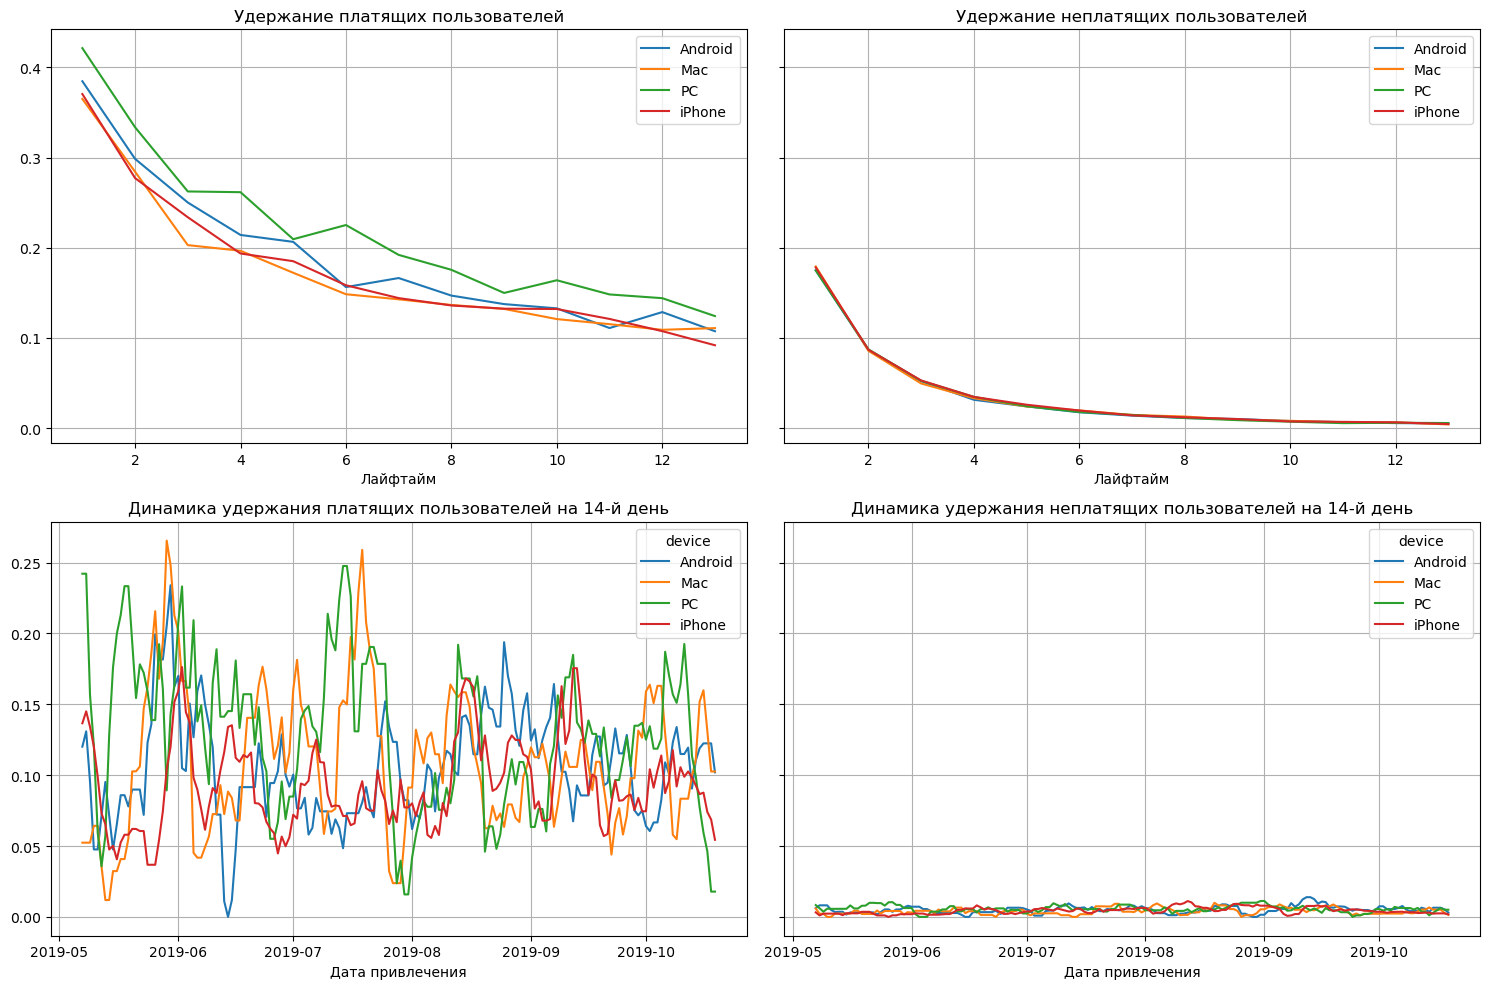

In [41]:
# считаем удержание по устройствам
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)
# строим графики
plot_retention(retention, retention_history, horizon_days, window=7)

Пользователи PC хуже конвертируются в покупателей. Пользователи Android лучше, и самая высокая конверсия в покупателей у пользователей Mac и iPhone. Но сделав покупку, пользователи Mac и iPhone реже заходят в приложение.

**Выводы:**
- реклама, направленная на привлечение пользователей в целом не окупается;
- реклама, направленная на привлечение пользователей с PC окупается, а для остальных устройств не окупается;
- реклама, направленная на привлечение пользователей из USA, оказывает негативное влияние на окупаемость рекламы;
- реклама, направленная на привлечение пользователей из каналов TipTop, AdNonSense и FaceBoom, оказывает негативное влияние на окупаемость рекламы;
- с увеличением реламных бюджетов конверсия в покупки и удержание пользователей осталось на том же уровне, дело может быть в том, что новые пользователи просто не приходят из рекламы; что подтвержается графиком привлечения новых пользователей: количество новых пользователей растет, но не такими быстрыми темпами, как увеличение рекламного бюджета;
- пользователи, которые сделали по покупку, хуже удерживаются, т.е. перестают заходить в приложение.

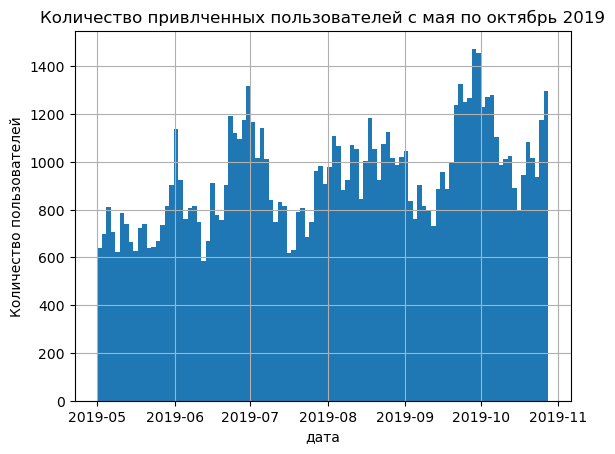

In [42]:
# построили график дат первого посещения пользователей
profiles['first_ts'].hist(bins=100)
plt.title('Количество привлченных пользователей с мая по октябрь 2019')
plt.xlabel('дата')
plt.ylabel('Количество пользователей')
plt.show()

**Рекомендации:**
- выяснить почему пользователи, которым показывают рекламу, неохотно скачивают приложение;
- сменить тип оплаты рекламы;
- уменьшить или перераспределить рекламные бюджеты;
- выяснить, почему пользователи после покупки перестают заходить в приложение.

### Выводы
<div class="alert alert-block alert-success">
    
Причины неэффективности привлечения пользователей:
    
- реклама может быть направлена на пользователей, которым приложение не интересно - не та возрастная категория, не те интересы и т.п.
- могут возникнуть проблемы на этапе перехода с сайта или установки приложения;
- все пользователи, которые сделали покупку, перестают заходить в приложение, и соотвественно, не делают больше покупок;
- реклама, нацеленная на пользователей Mac, iPhone и Android не окупается;
- у рекламы в США бюджет постоянно растет, но эта реклама перестала окупаться, пользователи из США не заходят в приложение из рекламы;
- бюджет рекламы на канале TipTop постоянно растет, но реклама не окупается, пользователи не заходят в приложение с этого канала;
- следующие после TipTop по объему рекламы - каналы AdNonSense и FaceBoom, и реклама на этих каналах также не окупается.

Рекомендации для отдела маркетинга:
- построить воронку продаж и посмотреть на каком этапе "отваливаются пользователи": почему они не кликают по рекламе, не заходят в приложение, не совершают покупки или повторные покупки;
- если реклама оплачивается за показы, то стоит пересмотреть форму оплаты рекламы в сторону оплату за скачивания приложения;
- попробовать сменить целевую аудиторию, которой показывается реклама;
- пользователи с канала lambdaMediaAds имеют высокий LTV, а значит, приносят больше денег, чем пользователи с других каналов, но рекламный бюджет на этот канал не тратится; следует рассмотреть этот канал как перспективный;
- пользователи с канала YRabbit имеют низкую стоимость привлечения и самую высокую окупаемость; этот канал также следует рассмотреть как перспективный. </div>